# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabaz_score

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
# set notebook verbosity
verbose = False

In [5]:
print(azdias.shape)
print(feat_info.shape)

(891221, 85)
(85, 4)


In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [7]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [8]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
if verbose:
    for col in azdias.columns:
        print(azdias[col].value_counts())
        print('Naturally missing:', azdias[col].isna().sum())
        print('Missing codes:', feat_info[feat_info['attribute'] == col].missing_or_unknown.values[0])
        print('=========================')

In [10]:
def parse_missing_codes(codes):
    """
    Parses 'missing_or_unknown' column (str) into Python list
    """
    parsed = []
    for code in codes[1:-1].split(','):
        if code.lstrip('-').isnumeric():
            parsed.append(int(code))
        elif code.isalpha():
            parsed.append(code)
    return parsed

In [11]:
# Identify missing or unknown data values and convert them to NaNs.
naturally_missing = []
coded_missing = []
for col, missing_codes in zip(azdias.columns, feat_info['missing_or_unknown']):
    missing_codes =  parse_missing_codes(missing_codes)
    # count "naturally" missing values
    naturally_missing.append(azdias[col].isna().sum())
    # replace coded missing values with NaN
    azdias[col] = azdias[col].apply(lambda x: np.nan if x in missing_codes else x)
    # count replaced (coded) missing values 
    coded_missing.append(azdias[col].isna().sum() - naturally_missing[-1])
# convert to numpy array
naturally_missing = np.array(naturally_missing)
coded_missing = np.array(coded_missing)
total_missing = naturally_missing + coded_missing

if verbose:
    print('Naturally missing values')
    print(naturally_missing)
    print('Coded missing values')
    print(coded_missing)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

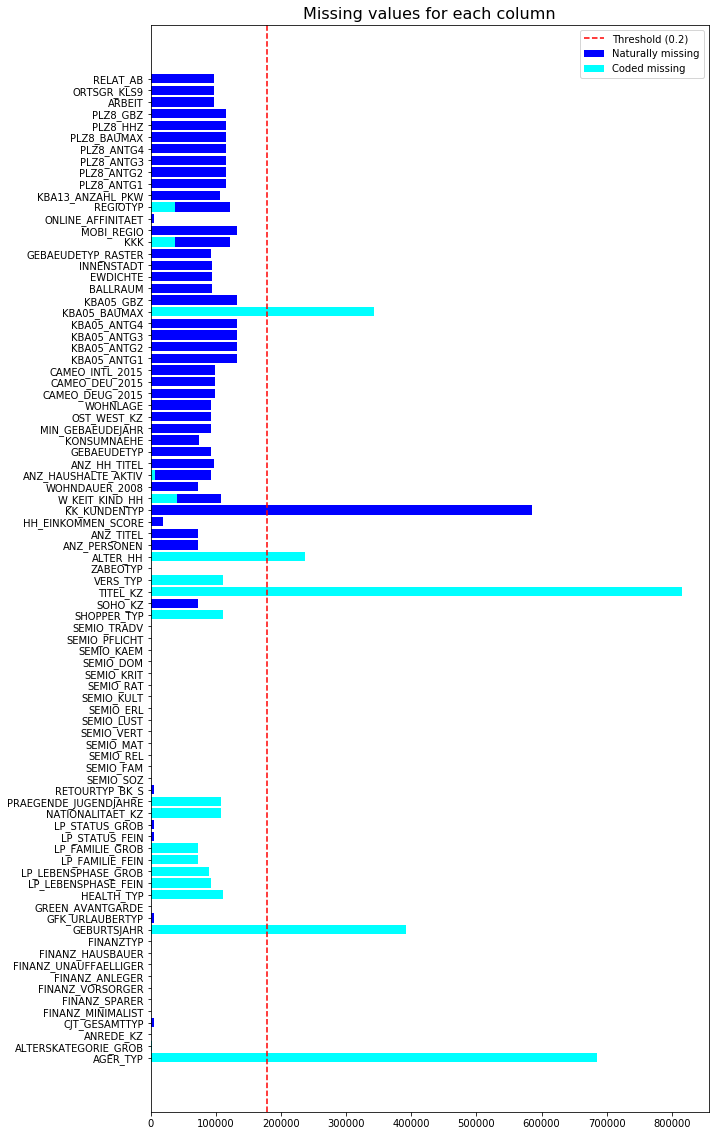

In [12]:
# Determine a threshold for the maximum percentage of missing values 
threshold_missing_col = 0.20
fig, ax = plt.subplots(1, 1, figsize=(10,20))
# plot missing values of each column
ax.barh(range(len(azdias.columns)), naturally_missing,  align='center', color='blue', label='Naturally missing')
ax.barh(range(len(azdias.columns)), coded_missing, align='center', color='cyan', label='Coded missing')
# plot vertical line, given threshold
ax.axvline(int(threshold_missing_col * azdias.shape[0]), color='red', ls='--', 
           label='Threshold ({:})'.format(threshold_missing_col))
ax.set_yticks(range(len(azdias.columns)))
ax.set_yticklabels(list(azdias.columns))
ax.set_title("Missing values for each column", fontsize=16)
ax.legend(loc='upper right')

In [13]:
# determining which and how many columns will be dropped
percentage = int(threshold_missing_col * 100)
max_missing = int(threshold_missing_col * azdias.shape[0])
columns_to_drop = []
print('Columns with more than {:2}% ({:6}) missing values:'.format(percentage, max_missing))
for i, n_missing in enumerate(total_missing):
    if n_missing > max_missing:
        print('{:20} | {:6}'.format(azdias.columns[i], n_missing))
        columns_to_drop.append(azdias.columns[i])
print('Total columns to drop:', len(columns_to_drop))

Columns with more than 20% (178244) missing values:
AGER_TYP             | 685843
GEBURTSJAHR          | 392318
TITEL_KZ             | 889061
ALTER_HH             | 310267
KK_KUNDENTYP         | 584612
KBA05_BAUMAX         | 476524
Total columns to drop: 6


In [14]:
# Remove the outlier columns from the dataset
azdias.drop(columns=columns_to_drop, inplace=True)

#### Discussion 1.1.2: Assess Missing Data in Each Column
By looking at the bar plot it can be seen that there are 6 columns that are clearly outliers in the missing values distribution. We can identify these columns by having a threshold of 0.2 on the maximum number of entries with missing values, per column. I've chosen this threshold because a lower one would drop too many features (with a threshold equal to 0.1, 46 features would be dropped). The columns are:
- *AGER_TYP* (685843 missing values)
- *GEBURTSJAHR* (392318 missing values)
- *TITEL_KZ* (889061 missing values)
- *ALTER_HH* (310267 missing values)
- *KK_KUNDENTYP* (584612 missing values)
- *KBA05_BAUMAX* (476524 missing values)

Also, while these 6 columns have no clear correlation, we can see that the missing values in the remaining columns appear to be similar accross different features if those features belong to the same "macrocategory" (e.g., RR3 micro-cell features starting with KBA05 or PLZ8 macro-cell features starting with PLZ8).

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [15]:
def compare_subsets(azdias, threshold, ncols_compare=10, show_graphs=False):
    # functions that, given the dataset and a threshold, compares ncols_compare columns without missing values
    # across the two subsets of data (based on threshold)
    azdias['missing_row'] = azdias.isna().sum(axis=1) / len(azdias.columns)
    above = azdias.loc[azdias['missing_row'] > threshold].drop(columns='missing_row')
    below = azdias.loc[azdias['missing_row'] <= threshold].drop(columns='missing_row')
    azdias.drop(columns='missing_row', inplace=True)
    if verbose:
        print('Threshold on rows = ', threshold, ', accepted rows: ', below.shape[0], ', dropped rows: ', above.shape[0], sep='')
    if show_graphs:
        columns_no_missing = azdias.columns[azdias.isna().sum() == 0]
        for col in columns_no_missing[:ncols_compare]:
            fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
            sns.countplot(x=col, data=below, ax=ax1)
            ax1.set_title('Column: ' + col + ', subset: accepted')
            sns.countplot(x=col, data=above, ax=ax2)
            ax2.set_title('Column: ' + col + ', subset: dropped')
    return below, above

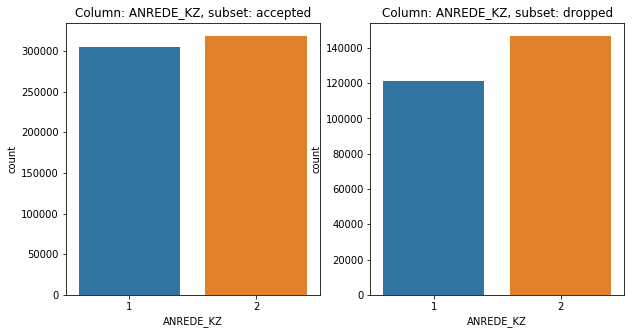

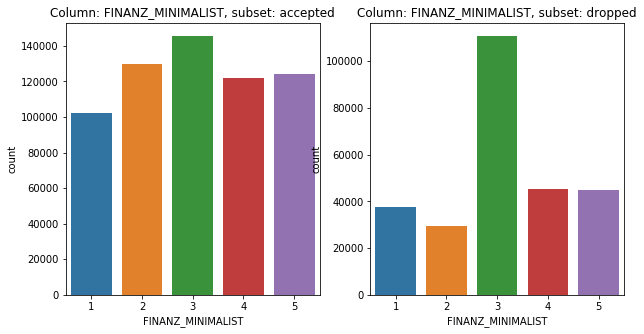

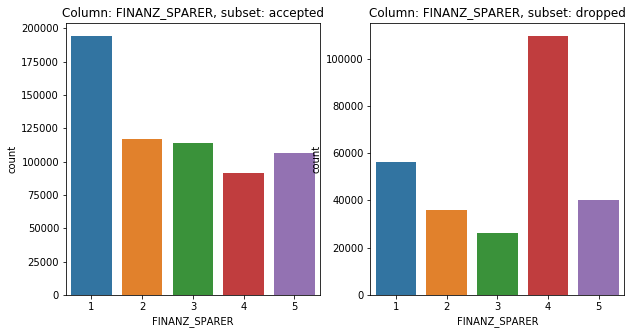

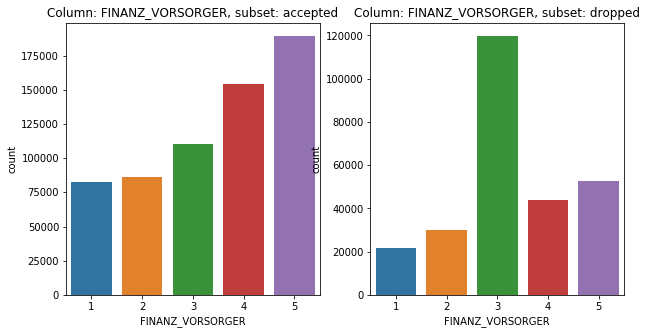

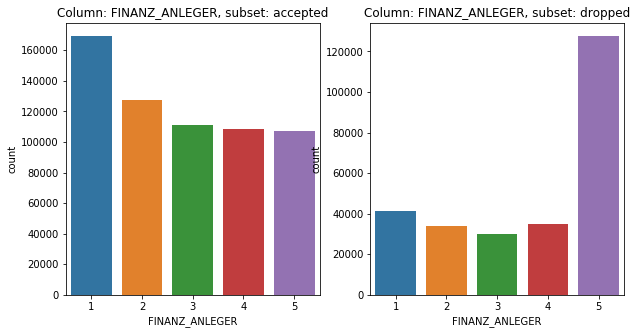

In [16]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
threshold_missing = 0
accepted, dropped = compare_subsets(azdias, threshold_missing, ncols_compare=5, show_graphs=True)

#### Discussion 1.1.3: Assess Missing Data in Each Row

We can see that, although some columns have a similar distribution accross the two subsets (e.g. ANREDE_KZ, GREEN_AVANTGARDE), most of the columns have a different distribution. So the two subsets are actually different, and we will need to revisit the data later on.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [17]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [18]:
def get_onehot_cols(df, feat_info, max_unique=9):
    """
    Given demographics data and feature attributes dataframes, returns two lists:
        - names of the columns that should be one-hot encoded
        - names of the columns that should be dropped
    Each columns of the first list has no more than max_unique unique values in the original data.
    """
    cols_onehot = []
    cols_drop = []
    for col in feat_info[feat_info['type'] == 'categorical'].attribute:
        if col in df.columns:
            u = df[col].unique()
            if verbose:
                print('Column ' + col + ', unique values:', u)
            if len(u) > 2:
                if len(u) < max_unique:
                    cols_onehot.append(col)
                else:
                    cols_drop.append(col)
    return cols_onehot, cols_drop

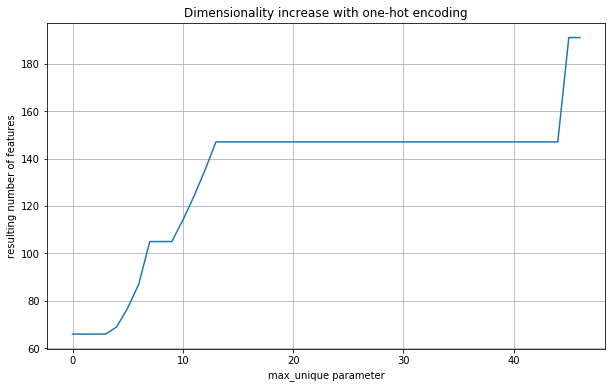

In [19]:
dimensions = []
max_uniques = np.arange(47)
for max_unique in max_uniques:
    cols_onehot, cols_drop = get_onehot_cols(accepted, feat_info, max_unique=max_unique)
    dimensions.append(pd.get_dummies(accepted, columns=cols_onehot).drop(columns=cols_drop).shape[1])

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(max_uniques, dimensions)
ax.set_title('Dimensionality increase with one-hot encoding')
ax.set_xlabel('max_unique parameter')
ax.set_ylabel('resulting number of features')
ax.grid(True)

In [20]:
# performing one-hot encoding
cols_onehot, cols_drop = get_onehot_cols(accepted, feat_info, max_unique=9)
encoded = pd.get_dummies(accepted, columns=cols_onehot).drop(columns=cols_drop)
# re-encoding non numeric feature
encoded['OST_WEST_KZ'] = encoded['OST_WEST_KZ'].apply(lambda x: 1 if x == 'W' else 0)

#### Discussion 1.2.1: Re-Encode Categorical Features
The only binary categorical feature that was re-encoded was *OST_WEST_KZ*, because it didn't have numeric values; its two labels 'W', 'O' were mapped into the numbers 0 and 1. The other binary categorical features were all numeric and didn't need to be re-encoded.

Regarding multi-level categoricals, I've decided to perform one-hot encoding on 8 columns out of 13; this is because I wanted to avoid a huge increase in the number of dimensions (**curse of dimensionality**). To help me decide which and how many features should be retained via one-hot encoding I used an helper function (`get_onehot_cols()`) that computes the names of columns that have no more than a certain number of unique values, which correspond to the increase in the dimensionality that each single column would provide. The plot above shows the resulting number of dimensions (against different values of the parameter). It should be noted that one single feature, *CAMEO_DEU_2015*, has 45 unique values (the spike at the right end of the plot).

Summing up: I'm one-hot encoding the features that have no more than **9** unique values each, and dropping the others. By doing this, we go from 79 features to 105 features, which is a good tradeoff.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [21]:
columns_to_drop = []
feat_info[feat_info['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


*from Data_Dictionary.md*:
### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [22]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# first variable: interval based on the years of youth
encoded['YOUTH_YEARS'] = encoded['PRAEGENDE_JUGENDJAHRE'].map({1: 1, 2: 1, 
                                                               3: 2, 4: 2,
                                                               5: 3, 6: 3, 7: 3,
                                                               8: 4, 9: 4,
                                                               10: 5, 11: 5, 12: 5, 13: 5,
                                                               14: 6, 16: 6})
# second variable: binary features, based on dominating movement (mainstream vs avantgarde)
encoded['YOUTH_MOVEMENT'] = encoded['PRAEGENDE_JUGENDJAHRE'].map({1: 0, 2: 1, 
                                                               3: 0, 4: 1,
                                                               5: 0, 6: 1, 7: 1,
                                                               8: 0, 9: 1,
                                                               10: 0, 11: 1, 12: 0, 13: 1,
                                                               14: 0, 16: 1})
columns_to_drop.append('PRAEGENDE_JUGENDJAHRE')

*from Data_Dictionary.md*
### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement

In [23]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
encoded['HOUSEHOLD_WEALTH'] = encoded['CAMEO_INTL_2015'].apply(lambda x: x[0]).astype(np.int64)
encoded['HOUSEHOLD_TYPE'] = encoded['CAMEO_INTL_2015'].apply(lambda x: x[1]).astype(np.int64)
columns_to_drop.append('CAMEO_INTL_2015')

In [24]:
columns_to_drop += ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX']

#### Discussion 1.2.2: Engineer Mixed-Type Features

Mixed type features, along with steps performed:
- **LP_LEBENSPHASE_FEIN**: dropped as it contains too many variations;
- **LP_LEBENSPHASE_GROB**: dropped as it contains too many variations;
- **PRAEGENDE_JUGENDJAHRE**: engineered into two features, one for the decade of youth and the other for the dominating movement;
- **WOHNLAGE**: retained as it can be seen as an ordinal feature;
- **CAMEO_INTL_2015**: engineered into two features, one for the wealth of the household and the other for the type
- **KBA05_BAUMAX**: dropped before because of too much missing data;
- **PLZ8_BAUMAX**: dropped as it is redundant data.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [25]:
cleaned = encoded.drop(columns=columns_to_drop)
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Columns: 104 entries, ALTERSKATEGORIE_GROB to HOUSEHOLD_TYPE
dtypes: float64(40), int64(25), uint8(39)
memory usage: 357.0 MB


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [26]:
def clean_data(df, t_miss_row=0, max_unique=9):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: 
    - Demographics DataFrame
    - threshold (percentage) of missing values in columns
    - threshold (percentage) of missing values in rows
    - max number of unique features for features to be one-hot encoded
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # create deep copy of the df to avoid modifying it
    df = df.copy(deep=True)
    # obtain feature info (for missing codes)
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
    
    # convert missing value codes into NaNs
    for col, missing_codes in zip(df.columns, feat_info['missing_or_unknown']):
        missing_codes =  parse_missing_codes(missing_codes)
        df[col] = df[col].apply(lambda x: np.nan if x in missing_codes else x)
    
    # remove columns with too mcuh missing values
    df.drop(columns=['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], inplace=True)
    # remove rows with more than t_miss_row % of missing values
    accepted, dropped = compare_subsets(df, t_miss_row)

    # converting binary feature into numeric 
    accepted['OST_WEST_KZ'] = accepted['OST_WEST_KZ'].apply(lambda x: 1 if x == 'W' else 0)
    # one-hot encoding
    cols_onehot, cols_drop = get_onehot_cols(accepted, feat_info, max_unique=9)
    encoded = pd.get_dummies(accepted, columns=cols_onehot).drop(columns=cols_drop)
    
    ''' old version
    cols_to_drop = [c for c in feat_info[feat_info['type'] == 'categorical'].attribute 
                    if c not in onehot_cols and c in accepted.columns]
    encoded = pd.get_dummies(accepted, columns=cols_onehot)
    '''
    
    # this next line is horrible, but needed because of one-hot encoding
    # in the customers data, the value "5" for the "GEBAEUDETYP" column is missing
    # so this column isn't generated in step 3 and it causes problems with pca, scaler etc
    if 'GEBAEUDETYP_5.0' not in encoded.columns:
        encoded['GEBAEUDETYP_5.0'] = np.zeros(encoded.shape[0])
        
    # engineering new features
    encoded['YOUTH_YEARS'] = encoded['PRAEGENDE_JUGENDJAHRE'].map({1: 1, 2: 1, 
                                                               3: 2, 4: 2,
                                                               5: 3, 6: 3, 7: 3,
                                                               8: 4, 9: 4,
                                                               10: 5, 11: 5, 12: 5, 13: 5,
                                                               14: 6, 15: 6})
    encoded['YOUTH_MOVEMENT'] = encoded['PRAEGENDE_JUGENDJAHRE'].map({1: 0, 2: 1, 
                                                                   3: 0, 4: 1,
                                                                   5: 0, 6: 1, 7: 1,
                                                                   8: 0, 9: 1,
                                                                   10: 0, 11: 1, 12: 0, 13: 1,
                                                                   14: 0, 15: 1})

    encoded['HOUSEHOLD_WEALTH'] = encoded['CAMEO_INTL_2015'].apply(lambda x: 
                                                                   x[0] if x is not np.nan else np.nan).astype(np.float64)
    encoded['HOUSEHOLD_TYPE'] = encoded['CAMEO_INTL_2015'].apply(lambda x: 
                                                                 x[1] if x is not np.nan else np.nan).astype(np.float64)
    # drop (now) useless columns
    cols_to_drop = ['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015', 
                    'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX']
    clean = encoded.drop(columns=cols_to_drop).reset_index(drop=True)
    # Return the cleaned dataframe
    return clean, dropped

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [27]:
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
pop_clean, pop_dropped = clean_data(azdias)

In [28]:
if verbose:
    print('Number of rows with missing values is:', pop_clean.isna().sum(axis=1).astype(bool).sum())

In [29]:
# imputation of missing values 
imputer = Imputer(strategy='mean')
pop_imputed = imputer.fit_transform(pop_clean)

In [30]:
# applying feature scaling
scaler = StandardScaler()
pop_scaled = scaler.fit_transform(pop_imputed)

### Discussion 2.1: Apply Feature Scaling
I applied two steps during feature scaling:
- The first step involves imputing eventual missing values. Each missing value is imputed as the mean of the column it belongs to.
- The data is then scaled using a StandardScaler, i.e. each feature is scaled to have mean = 0 and standard deviation = 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [31]:
# Apply PCA to the data.
pca = PCA()
pca.fit(pop_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

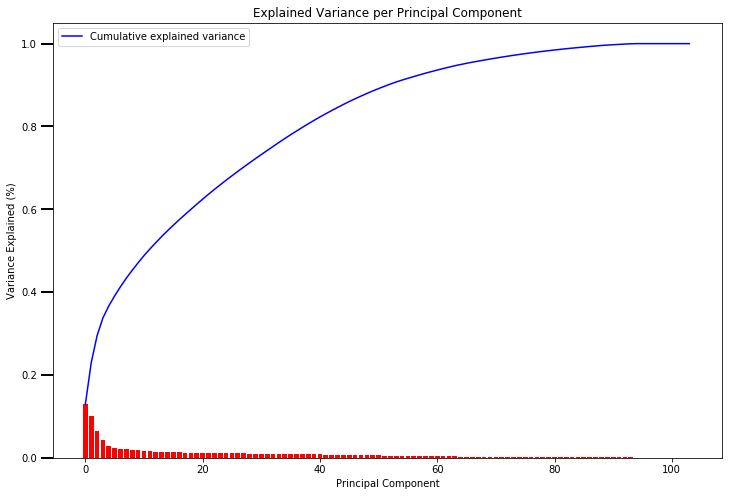

In [32]:
# Investigate the variance accounted for by each principal components
vals = pca.explained_variance_ratio_
num_components = len(vals)
ind = np.arange(num_components)
cumvals = np.cumsum(vals)

plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
ax.bar(ind, vals, color='red')
ax.plot(ind, cumvals, color='blue', label='Cumulative explained variance')

ax.yaxis.set_tick_params(width=2, length=12)
ax.set_title('Explained Variance per Principal Component')
ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained (%)")
ax.legend()

In [33]:
# how many components to capture at least 80% variance?
np.where(cumvals > 0.8)[0][0]

38

In [34]:
# Re-apply PCA to the data while selecting for number of components to retain.
n_components = 38
pca = PCA(n_components=n_components)
pop_final = pca.fit_transform(pop_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

The final number of components I used in PCA is the number of components that allows to explain at least 80% of the data variance, which is **38**. This will greatly decrease the data dimensionality (less than half) while also retaining a good amount of variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [35]:
def pca_weights(df, pca, comp, ret_all=False):
    weights = pd.Series(np.round(pca.components_[comp], 4))
    weights.index = df.columns
    weights.sort_values(inplace=True)
    
    weights = pd.concat([weights[:10], weights[-10:]])
    fig, ax = plt.subplots(figsize = (12,8))
    weights.plot(ax=ax, kind='barh')
    ax.set_xlabel("Feature Weights")
    ax.set_ylabel("Feature names")

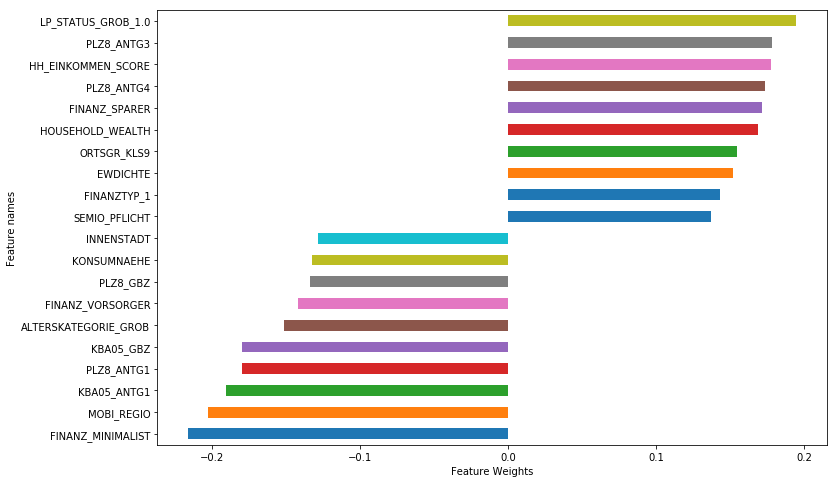

In [36]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weights(pop_clean, pca, 0)

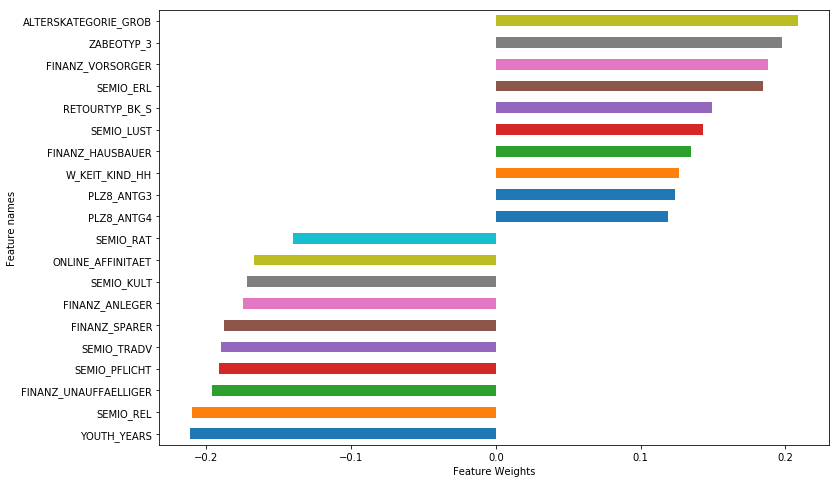

In [37]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weights(pop_clean, pca, 1)

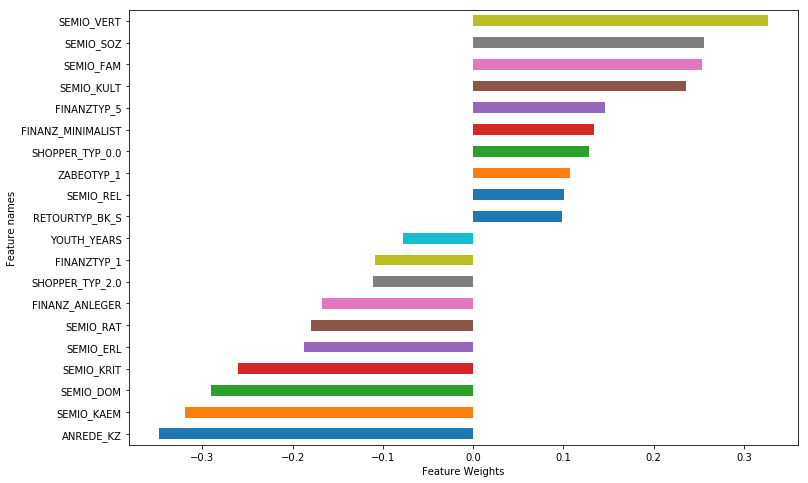

In [38]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weights(pop_clean, pca, 2)

### Discussion 2.3: Interpret Principal Components
What additional insights can we obtain by looking at the first 3 components?
1. The first component is showing us a positive correlation between *LP_STATUS_GROB_1* (binary feature indicating low income earners) and *HOUSEHOLD_WEALTH* (lies in the range 1-5 where higher values indicates poorer households), so it's a reasonable relationship. It's also catching some correlations between features regarding the geographical area (*PLZ8_* and *KBA05_*). Another interesting relationship is the positive correlation between *MOBI_REGIO* (movement patterns), *KONSUMNAEHE* (distance from building to point of sale) and *INNENSTADT* (distance to city center).
2. The second component captures a negative correlation between *ALTERSKATEGORIE_GROB* (estimated age) and *YOUTH_YEARS* (decade of youth), which makes absolute sense (the older a person, the farther its youth decade). It also captures some positive correlation between some personality typologies *SEMIO* (religious, dutiful, tradional-minded) which also makes sense from my point of view. 
3. The third component is also focused on the features regarding the personality typology. From the graph we can see it captures two groups of correlated personality typologies (combative attitude, dominant-minded, critical-minded and event-oriented vs dreamful, family-minded, socially-minded and cultural-minded). Also, these two groups are negatively correlated.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.

4- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [43]:
kme_scores = []
clusters_range = np.arange(2, 26)
for n_clusters in clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, n_jobs=-1).fit(pop_final)
    kme_scores.append(abs(kmeans.score(pop_final)))

Text(0,0.5,'KMeans Score')

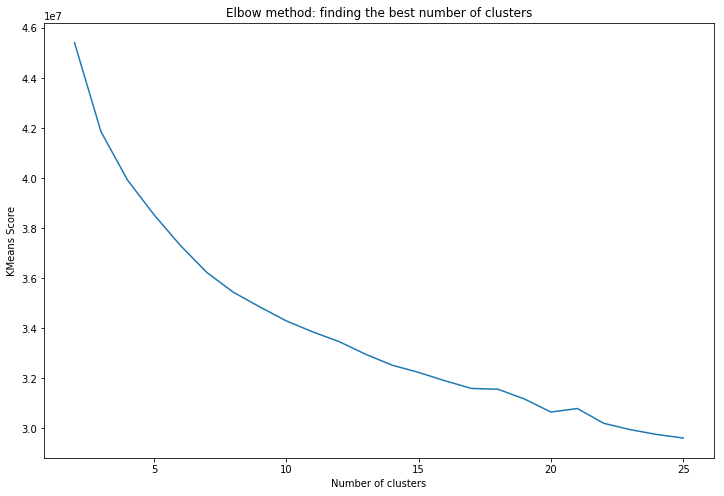

In [44]:
# Investigate the change in within-cluster distance across number of clusters.
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(clusters_range, kme_scores)
ax.set_title('Elbow method: finding the best number of clusters')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('KMeans Score')

In [45]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
n_clusters = 17
kmeans = KMeans(n_clusters=n_clusters).fit(pop_final)
pop_clusters = kmeans.labels_

### Discussion 3.1: Apply Clustering to General Population

I'm segmenting the population into 17 clusters. This is a reasonable number because it's the "elbow" point in the above graph.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [46]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [47]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
cus_clean, cus_dropped = clean_data(customers)
cus_final = pca.transform(scaler.transform(imputer.transform(cus_clean)))
cus_clusters = kmeans.predict(cus_final)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

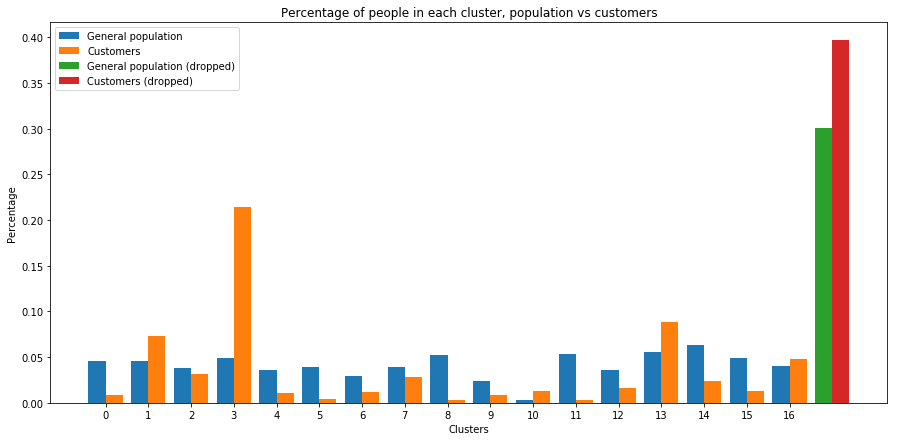

In [48]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
bar_width = 0.2
pop_size = len(pop_clusters) + len(pop_dropped)
cus_size = len(cus_clusters) + len(cus_dropped)
index, pop_counts = np.unique(pop_clusters, return_counts=True)
index, cus_counts = np.unique(cus_clusters, return_counts=True)

fig, ax = plt.subplots(figsize=(15,7))
ax.bar(index-bar_width, pop_counts/pop_size, 
       bar_width*2, label="General population")
ax.bar(index+bar_width, cus_counts/cus_size, 
       bar_width*2, label="Customers")
ax.bar(index[-1]+1-bar_width, len(pop_dropped)/pop_size,
       bar_width*2, label="General population (dropped)")
ax.bar(index[-1]+1+bar_width, len(cus_dropped)/cus_size,
       bar_width*2, label="Customers (dropped)")

ax.set_xlabel('Clusters')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of people in each cluster, population vs customers')
ax.set_xticks(index)
ax.legend()

In [103]:
def inverse_transform_point(pt, pca, scaler, df):
    pt = scaler.inverse_transform(pca.inverse_transform(pt))
    return pd.DataFrame([pt], index=['Centroid'], columns=df.columns)

characteristic_features = ['ALTERSKATEGORIE_GROB', 'YOUTH_YEARS', 'YOUTH_MOVEMENT', 'HOUSEHOLD_WEALTH', 'HOUSEHOLD_TYPE',
                           'FINANZTYP_1', 'FINANZTYP_2', 'FINANZTYP_3', 'FINANZTYP_4', 'FINANZTYP_5', 'FINANZTYP_6',
                           'LP_FAMILIE_GROB_1.0', 'LP_FAMILIE_GROB_2.0', 'LP_FAMILIE_GROB_3.0', 'LP_FAMILIE_GROB_4.0',
                           'LP_FAMILIE_GROB_5.0', 'LP_STATUS_GROB_1.0', 'LP_STATUS_GROB_2.0', 'LP_STATUS_GROB_3.0',
                           'LP_STATUS_GROB_4.0', 'LP_STATUS_GROB_5.0', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT',
                           'MOBI_REGIO', 'KONSUMNAEHE']
#pd.set_option("max_rows", None)

In [104]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centroid = inverse_transform_point(kmeans.cluster_centers_[3], pca, scaler, cus_clean)
centroid[characteristic_features].T

,Centroid
ALTERSKATEGORIE_GROB,3.340626
YOUTH_YEARS,3.456579
YOUTH_MOVEMENT,1.001548
HOUSEHOLD_WEALTH,2.032494
HOUSEHOLD_TYPE,3.642422
FINANZTYP_1,-0.030258
FINANZTYP_2,0.240250
FINANZTYP_3,0.048438
FINANZTYP_4,0.010452
FINANZTYP_5,0.311300


In [106]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid = inverse_transform_point(kmeans.cluster_centers_[11], pca, scaler, cus_clean)
centroid[characteristic_features].T

,Centroid
ALTERSKATEGORIE_GROB,1.792685
YOUTH_YEARS,5.826593
YOUTH_MOVEMENT,0.092144
HOUSEHOLD_WEALTH,4.438731
HOUSEHOLD_TYPE,2.034461
FINANZTYP_1,0.636845
FINANZTYP_2,0.000138
FINANZTYP_3,0.021132
FINANZTYP_4,0.183499
FINANZTYP_5,0.039161


### Discussion 3.3: Compare Customer Data to Demographics Data
To infer what kind of people are represented by a certain cluster, I decided to take the centroid of the cluster and transform it back to the original data space using the `inverse_transform` method of the PCA and Scaler objects. 
The coordinates (i.e. feature values) of the resulting point, unlike the original data, won't be strictly integers; this is due to the fact that the centroid doesn't have to be (and usually isn't) part of the original data. Still, this is not a problem at all since we can interpret decimal values as bigger ranges.
Finally, from this resulting point I take a subset of 'characteristic' features to investigate.

Now, talking about the clusters themselves:
1. I've chosen cluster 3 as a **overrepresented cluster**, which is a cluster that represent segments of the population that are relatively **popular** with the company. By looking at the centroid we can infer the following about a person (assuming male gender) belonging to this cluster:
    - He's middle-aged, i.e. he's between 46-60 years old;
    - The dominating movement of his youth was mainstream;
    - He has an high income;
    - He shows low movement patterns;
    - He belongs to a prosperous/comfortable household; this household is usually a couple (possibly a mature couple), a family with school-age children or a multiperson (e.g. shared flat or multi-generational) household;
    - He lives in a medium density area (150 - 319 households per km^2), usually up to 15-20 km far from the city centre;
    - He's in between the investor (ANLEGER) and inconspicuous (UNAUFFAELLIGER) financial type; 
    - There's at least one RA1-consumption cell within 1 km from where he lives.
    
    
2. I've chosen cluster 11 as a **underrepresented cluster**, which is a cluster that represent segments of the population that are relatively **unpopular** with the company. By looking at the centroid we can infer the following about a person (assuming male gender) belonging to this cluster:
    - He's younger than someone belonging to cluster 3, i.e. he's up to 45 years old;
    - The dominating movement of his youth was avantgarde;
    - He has a low income;
    - He shows high movement patterns;
    - He belongs to a less affluent household; this household is usually a young couple with children or a single (meaning one person) household;
    - He lives in a high density area (320 - 999 households per km^2), usually up to 5 km far from the city centre;
    - He usually has a low financial interest (MINIMALIST) financial type; 
    - There's at least one RA1-consumption cell within 250 from where he lives.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.